# 01 · EDA Refatorado: Análise Exploratória Inteligente para Detecção de Lavagem de Dinheiro

Este notebook implementa uma análise exploratória estruturada e inteligente, seguindo as melhores práticas de ciência de dados. O fluxo é otimizado para priorizar variáveis com maior poder preditivo para fraude, garantindo eficiência e insights acionáveis.

## Estrutura do Notebook

1. **Construção do Dataset Mestre**: Integração de todas as fontes de dados (transações, contas, padrões)
2. **Análise Exploratória Inteligente**: Priorização por Information Value (IV) e exploração direcionada
3. **Conclusão e Storytelling**: Síntese dos insights e próximos passos

## Objetivo

Detectar padrões de lavagem de dinheiro através de análise de dados transacionais, priorizando variáveis com maior capacidade preditiva.

In [1]:
# Setup e Imports Centralizados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configurações globais
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Caminhos de dados
data_raw_dir = Path('../data/raw')
data_processed_dir = Path('../data/processed')

print("Setup completo.")

Setup completo.


In [2]:
# Carregamento de Todas as Fontes de Dados Raw
print("Carregando fontes de dados...")

# Transações
df_trans = pd.read_csv(data_raw_dir / 'HI-Small_Trans.csv')
print(f"Transações: {df_trans.shape[0]:,} linhas, {df_trans.shape[1]} colunas")

# Contas
df_accounts = pd.read_csv(data_raw_dir / 'HI-Small_accounts.csv')
print(f"Contas: {df_accounts.shape[0]:,} linhas, {df_accounts.shape[1]} colunas")

# Padrões de lavagem
with open(data_raw_dir / 'HI-Small_Patterns.txt', 'r') as f:
    patterns_content = f.read()

# Parsear padrões (implementação simplificada)
patterns_lines = patterns_content.strip().split('\n')
laundering_patterns = [line for line in patterns_lines if 'BEGIN LAUNDERING ATTEMPT' in line]
print(f"Padrões de lavagem identificados: {len(laundering_patterns)}")

print("Carregamento concluído.")

Carregando fontes de dados...
Transações: 5,078,345 linhas, 11 colunas
Contas: 518,581 linhas, 5 colunas
Padrões de lavagem identificados: 370
Carregamento concluído.


In [3]:
# Limpeza e Padronização Inicial

# Renomear colunas para clareza
df_trans_renamed = df_trans.rename(columns={
    'Account': 'From Account',
    'Account.1': 'To Account',
    'From Bank': 'From Bank ID',
    'To Bank': 'To Bank ID',
    'Is Laundering': 'is_fraud',
    'Payment Format': 'payment_format'
})

df_accounts_renamed = df_accounts.rename(columns={
    'Bank ID': 'Bank ID',
    'Account Number': 'Account Number',
    'Entity ID': 'Entity ID',
    'Entity Name': 'Entity Name',
    'Bank Name': 'Bank Name'
})

# Converter timestamp
df_trans_renamed['Timestamp'] = pd.to_datetime(df_trans_renamed['Timestamp'])

# Limpeza básica
df_trans_renamed = df_trans_renamed.dropna(subset=['Amount Paid', 'is_fraud'])
df_accounts_renamed = df_accounts_renamed.dropna()

print("Limpeza e padronização concluídas.")
print(f"Transações após limpeza: {df_trans_renamed.shape[0]:,} linhas")
print(f"Contas após limpeza: {df_accounts_renamed.shape[0]:,} linhas")

Limpeza e padronização concluídas.
Transações após limpeza: 5,078,345 linhas
Contas após limpeza: 518,581 linhas


In [4]:
# Enriquecimento de Dados (Merge)

# Merge com contas de origem
df_enriched = df_trans_renamed.merge(
    df_accounts_renamed,
    left_on=['From Bank ID', 'From Account'],
    right_on=['Bank ID', 'Account Number'],
    how='left',
    suffixes=('', '_from')
)

# Merge com contas de destino
df_enriched = df_enriched.merge(
    df_accounts_renamed,
    left_on=['To Bank ID', 'To Account'],
    right_on=['Bank ID', 'Account Number'],
    how='left',
    suffixes=('', '_to')
)

# Validar merge
missing_from = df_enriched['Entity ID'].isnull().sum()
missing_to = df_enriched['Entity ID_to'].isnull().sum()
total = len(df_enriched)

print("Enriquecimento concluído.")
print(f"Dataset final: {df_enriched.shape[0]:,} linhas, {df_enriched.shape[1]} colunas")
print(f"Contas origem encontradas: {(total - missing_from)/total:.1%}")
print(f"Contas destino encontradas: {(total - missing_to)/total:.1%}")

Enriquecimento concluído.
Dataset final: 5,078,345 linhas, 21 colunas
Contas origem encontradas: 100.0%
Contas destino encontradas: 100.0%


In [5]:
df_enriched.head(1)

,Timestamp,From Bank ID,From Account,To Bank ID,To Account,Amount Received,Receiving Currency,Amount Paid,Payment Currency,payment_format,...,Bank Name,Bank ID,Account Number,Entity ID,Entity Name,Bank Name_to,Bank ID_to,Account Number_to,Entity ID_to,Entity Name_to
0,2022-09-01 00:20:00,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,...,National Bank of Laramie,10,8000EBD30,800D232D0,Partnership #1,National Bank of Laramie,10,8000EBD30,800D232D0,Partnership #1


In [6]:
# Engenharia de Features de Risco

# Features temporais
df_enriched['hour'] = df_enriched['Timestamp'].dt.hour
df_enriched['date'] = df_enriched['Timestamp'].dt.date
df_enriched['is_night_transaction'] = df_enriched['hour'].between(22, 6)

# Features de rede
df_enriched['same_bank_transaction'] = df_enriched['From Bank ID'] == df_enriched['To Bank ID']
df_enriched['same_entity_transaction'] = df_enriched['Entity ID'] == df_enriched['Entity ID_to']

# Features de valor
q95_amount = df_enriched['Amount Paid'].quantile(0.95)
df_enriched['high_amount_risk'] = df_enriched['Amount Paid'] > q95_amount

# Features de entidade (se disponível)
if 'Entity Name' in df_enriched.columns:
    entity_types = ['Sole Proprietorship', 'Partnership', 'Corporation', 'Individual']
    for entity_type in entity_types:
        df_enriched[f'from_{entity_type.lower().replace(" ", "_")}_flag'] = \
            df_enriched['Entity Name'].str.contains(entity_type, na=False)

print("Engenharia de features concluída.")
print(f"Features criadas: {len(df_enriched.columns) - len(df_trans_renamed.columns)}")

Engenharia de features concluída.
Features criadas: 20


In [7]:
# Validação e Overview do Dataset Final

print(f"Dimensões: {df_enriched.shape[0]:,} por {df_enriched.shape[1]}")
print(f"Período: {df_enriched['date'].min()} até {df_enriched['date'].max()}")
print(f"Taxa de fraude: {df_enriched['is_fraud'].mean():.3%}")

# Estatísticas descritivas
numeric_cols = ['Amount Paid', 'Amount Received', 'hour']
display(df_enriched[numeric_cols].describe())

# Distribuição do target
fraud_dist = df_enriched['is_fraud'].value_counts(normalize=True)

Dimensões: 5,078,345 por 31
Período: 2022-09-01 até 2022-09-18
Taxa de fraude: 0.102%


,Amount Paid,Amount Received,hour
count,5.078345e+06,5.078345e+06,5.078345e+06
mean,4.509273e+06,5.988726e+06,1.049247e+01
std,8.697728e+08,1.037183e+09,7.362643e+00
min,1.000000e-06,1.000000e-06,0.000000e+00
25%,1.844800e+02,1.833700e+02,4.000000e+00
50%,1.414540e+03,1.411010e+03,1.000000e+01
75%,1.229784e+04,1.234627e+04,1.700000e+01
max,1.046302e+12,1.046302e+12,2.300000e+01


Funções locais implementadas com sucesso!


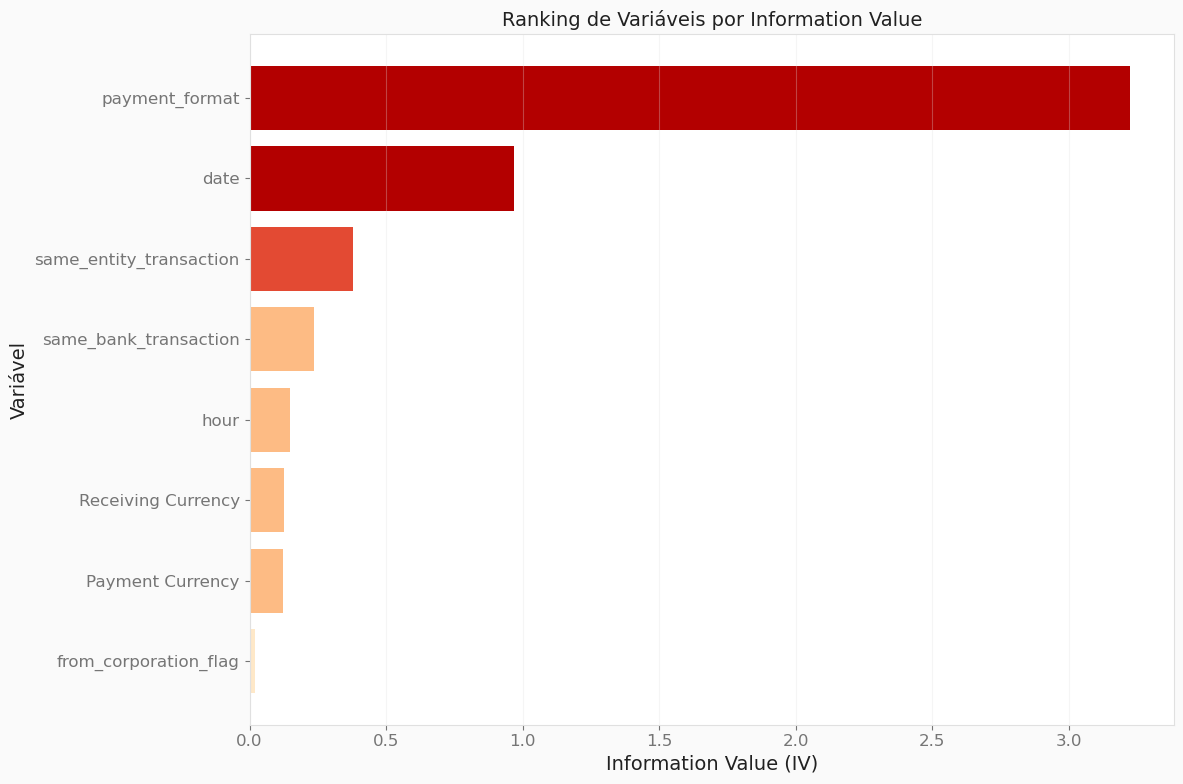

In [8]:
# Análise de Information Value (IV) - Priorização de Variáveis

# Adicionar caminho do projeto ao sys.path para importar módulos locais
import sys
from pathlib import Path
project_root = Path('../')
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# Importar função de cálculo de IV
from src.features.iv_calculator import calculate_iv, interpret_iv

# Calcular IV para todas as variáveis
iv_results = calculate_iv(df_enriched, 'is_fraud')

# Filtrar apenas variáveis com IV > 0.02 (preditivas) e não suspeitas
iv_filtered = iv_results[(iv_results['IV'] > 0.02) & (~iv_results['is_suspect'])].copy()

# Renomear coluna para português
iv_filtered = iv_filtered.rename(columns={'variable': 'variável'})

# Criar ranking por força preditiva
iv_filtered['Força'] = iv_filtered['IV'].apply(interpret_iv)

# Gráfico simples: Top 15 variáveis por IV
plt.figure(figsize=(12, 8))
top_iv = iv_filtered.head(15).copy()

# Cores por força preditiva
colors = {
    'Not predictive': '#f7f7f7',
    'Weak': '#fee8c8',
    'Medium': '#fdbb84',
    'Strong': '#e34a33',
    'Very strong': '#b30000'
}

color_map = top_iv['Força'].map(colors)
bars = plt.barh(top_iv['variável'], top_iv['IV'], color=color_map)

plt.xlabel('Information Value (IV)')
plt.ylabel('Variável')
plt.title('Ranking de Variáveis por Information Value', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Salvar ranking para próximos passos
iv_ranking = iv_filtered[['variável', 'IV', 'Força']].copy()

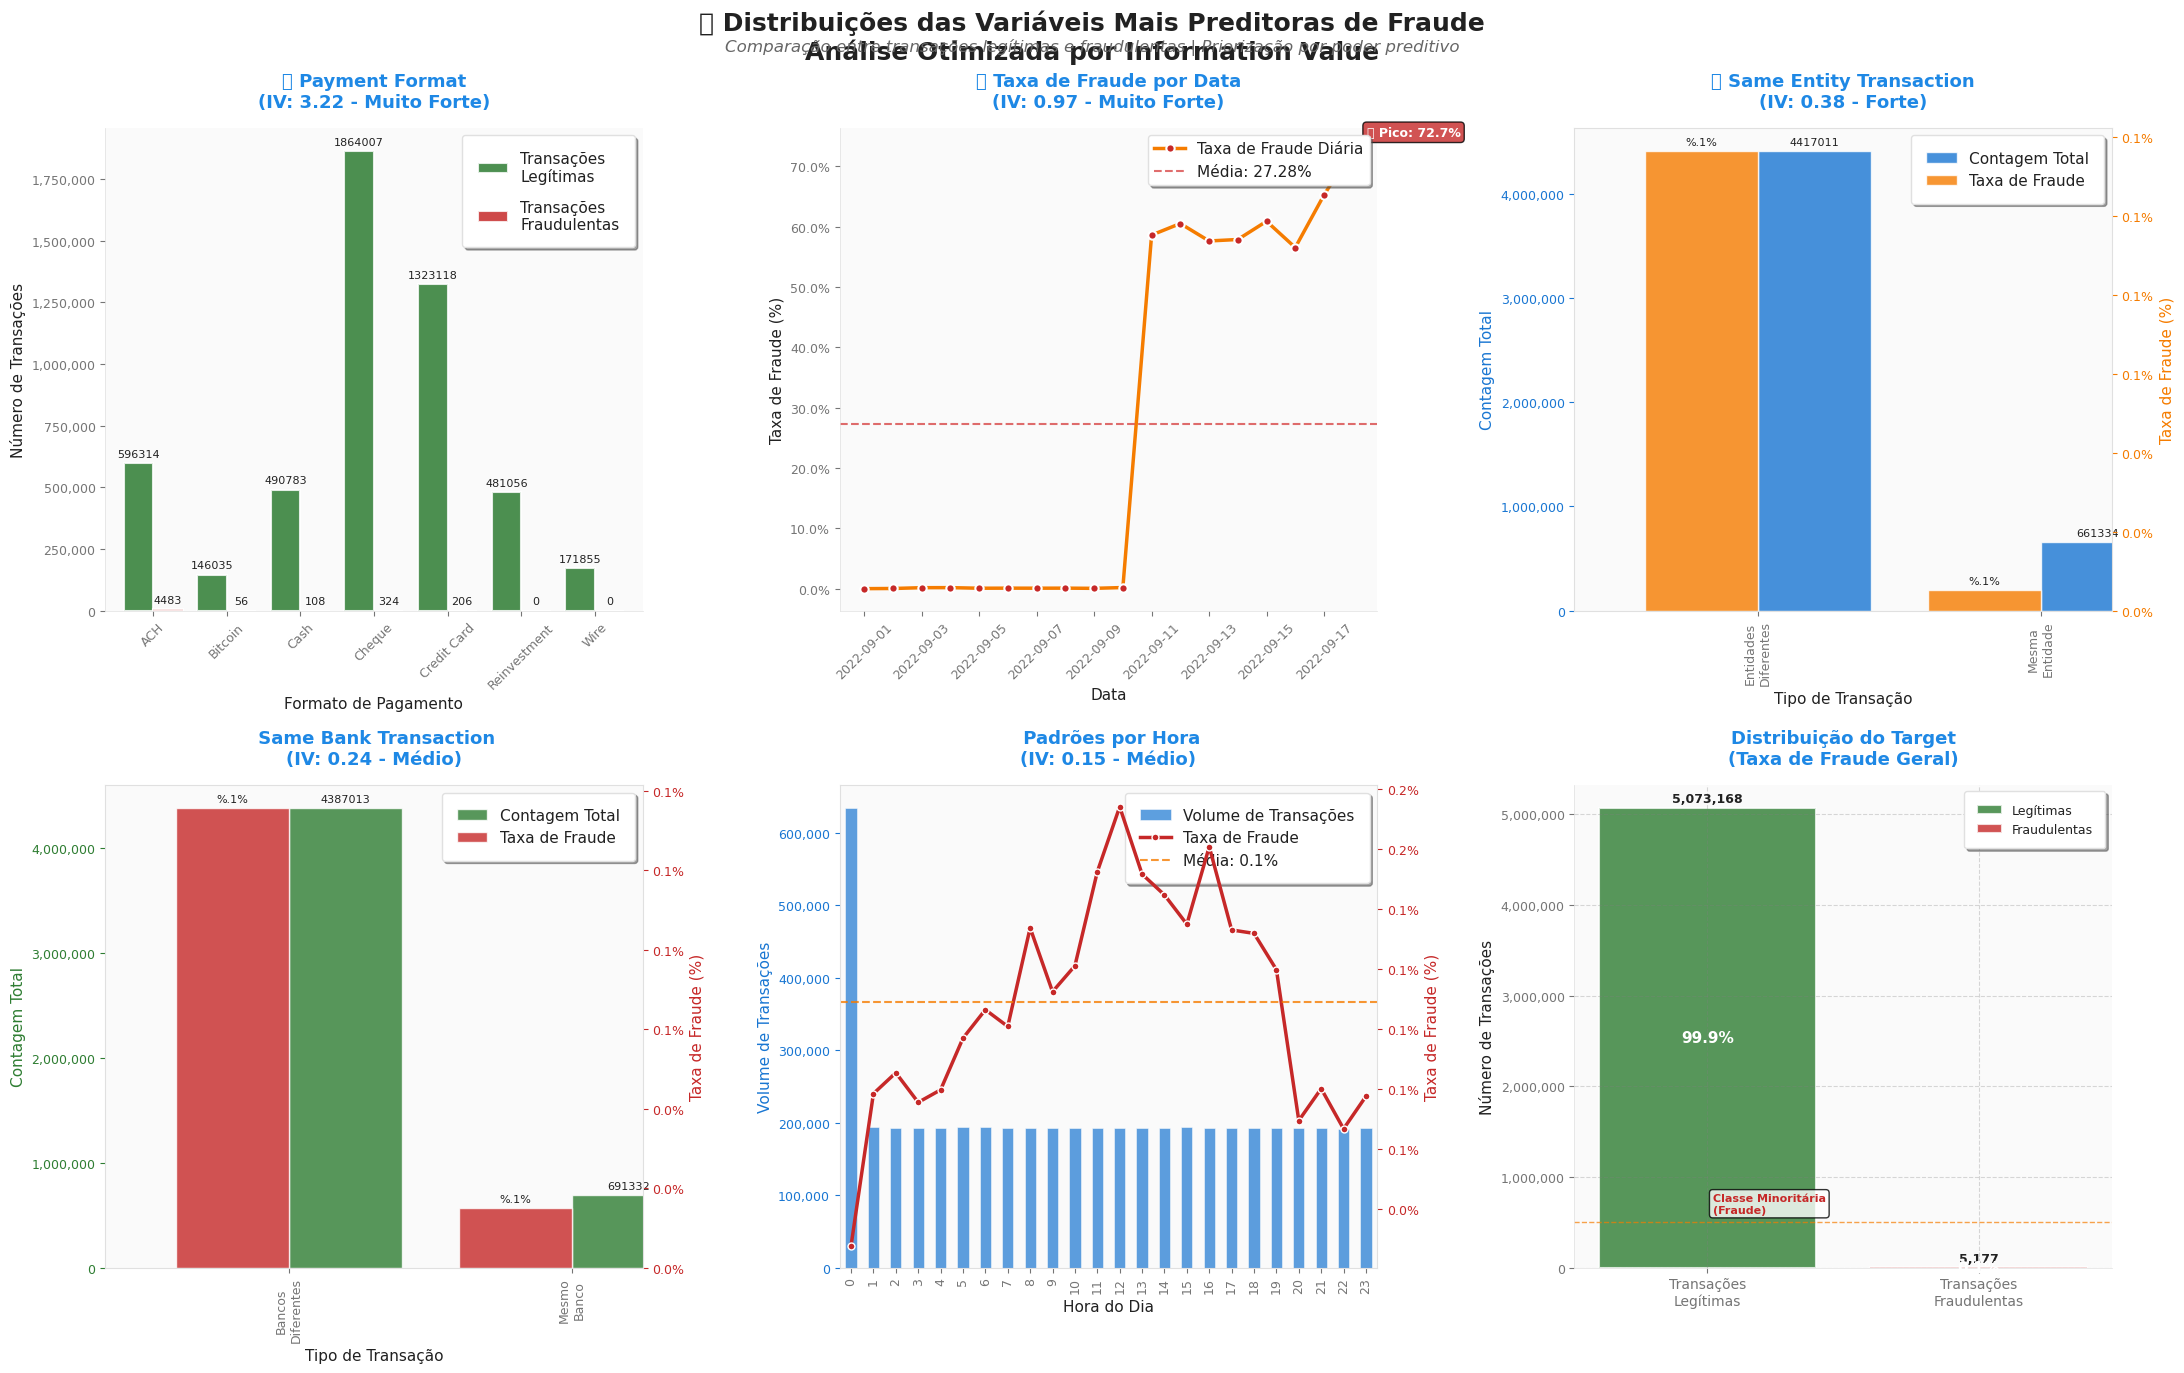


 Uma analise dos gráficos vemos que: 

1. PAYMENT FORMAT (IV: 3.224):
   - Formato mais arriscado: ACH (0.7%)
   - Formato menos arriscado: Wire (0.0%)

2. DATE (IV: 0.967):
   - Dia mais arriscado: 2022-09-18 (72.7%)
   - Dia menos arriscado: 2022-09-01 (0.0%)

3. SAME ENTITY TRANSACTION (IV: 0.380):
   - Mesmo entidade: 0.0% de risco
   - Entidades diferentes: 0.1% de risco

4. SAME BANK TRANSACTION (IV: 0.238):
   - Mesmo banco: 0.0% de risco
   - Bancos diferentes: 0.1% de risco

5. HOUR (IV: 0.149):
   - Hora mais arriscada: 12h (0.2%)
   - Hora menos arriscada: 0h (0.0%)


In [9]:
# Análise de Distribuições (Univariada) - Otimizada por IV

# Importar funções do módulo de plotting AML
import sys
from pathlib import Path
project_root = Path('../')
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

from src.features.aml_plotting import (
    setup_plot_design, create_figure_layout, 
    plot_payment_format, plot_date_fraud, plot_same_entity,
    plot_same_bank, plot_hour_patterns, plot_target_distribution,
    print_statistical_analysis
)

# Criar todos os gráficos usando as funções modulares
COLORS = setup_plot_design()
fig, axes = create_figure_layout()

# Criar cada gráfico
plot_payment_format(axes[0,0], df_enriched, COLORS)
plot_date_fraud(axes[0,1], df_enriched, COLORS)
plot_same_entity(axes[0,2], df_enriched, COLORS)
plot_same_bank(axes[1,0], df_enriched, COLORS)
plot_hour_patterns(axes[1,1], df_enriched, COLORS)
plot_target_distribution(axes[1,2], df_enriched, COLORS)

plt.tight_layout()
plt.show()

# Análise estatística
print_statistical_analysis(df_enriched, iv_ranking)

Transações fraudulentas parseadas: 3209


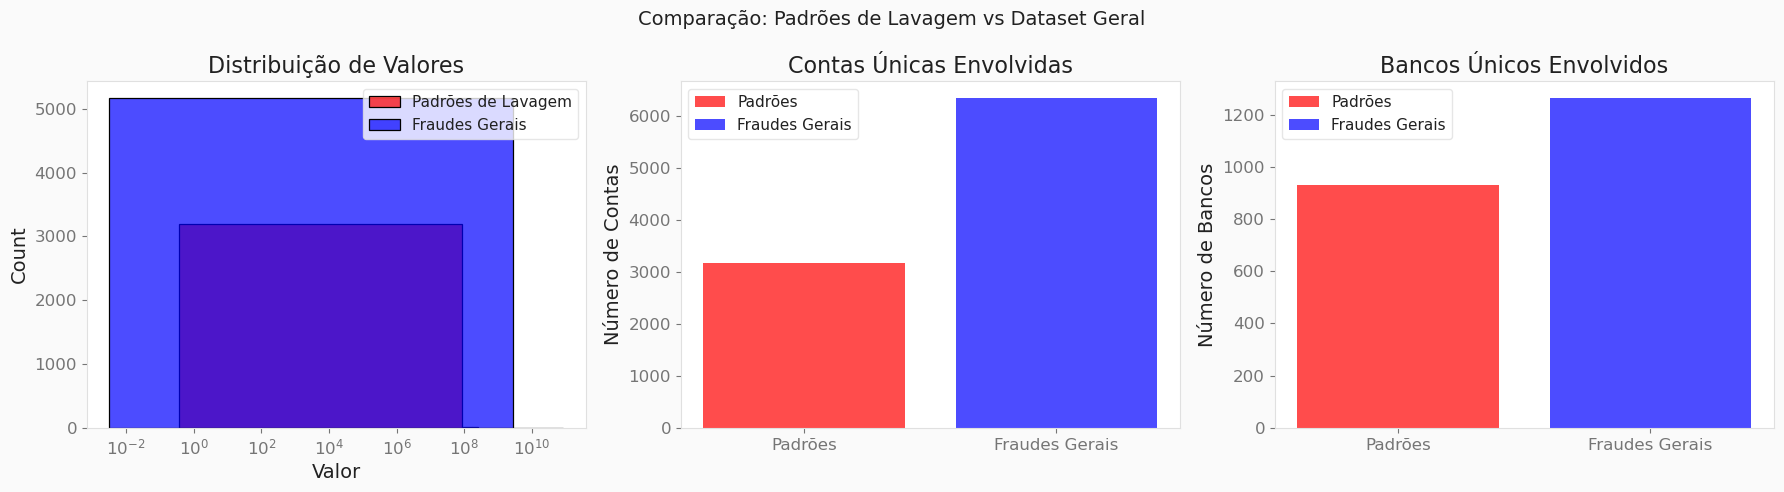

Características dos padrões de lavagem:
Valor médio: $2,720,119.48
Valor máximo: $2,597,164,367.66
Contas envolvidas: 3170
Bancos envolvidos: 931


In [10]:
# Análise de Padrões de Lavagem

# Parsear padrões de lavagem (versão simplificada)
fraudulent_transactions = []
for line in patterns_lines:
    if ',' in line and len(line.split(',')) >= 6:
        parts = line.split(',')
        try:
            fraudulent_transactions.append({
                'timestamp': parts[0],
                'from_bank': parts[1],
                'from_account': parts[2],
                'to_bank': parts[3],
                'to_account': parts[4],
                'amount': float(parts[5])
            })
        except:
            continue

patterns_df = pd.DataFrame(fraudulent_transactions)
print(f"Transações fraudulentas parseadas: {len(patterns_df)}")

# Análise comparativa
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Comparação: Padrões de Lavagem vs Dataset Geral', fontsize=14)

# Distribuição de valores
if len(patterns_df) > 0:
    sns.histplot(patterns_df['amount'], bins=30, ax=axes[0], alpha=0.7, label='Padrões de Lavagem', color='red')
    sns.histplot(df_enriched[df_enriched['is_fraud'] == 1]['Amount Paid'], bins=30, ax=axes[0], alpha=0.7, label='Fraudes Gerais', color='blue')
    axes[0].set_title('Distribuição de Valores')
    axes[0].set_xlabel('Valor')
    axes[0].set_xscale('log')
    axes[0].legend()

    # Contas únicas
    unique_accounts_patterns = len(set(patterns_df['from_account'].tolist() + patterns_df['to_account'].tolist()))
    unique_accounts_general = len(set(df_enriched[df_enriched['is_fraud'] == 1]['From Account'].astype(str).tolist() + 
                                      df_enriched[df_enriched['is_fraud'] == 1]['To Account'].astype(str).tolist()))
    
    axes[1].bar(['Padrões', 'Fraudes Gerais'], [unique_accounts_patterns, unique_accounts_general], 
               color=['red', 'blue'], alpha=0.7, label=['Padrões', 'Fraudes Gerais'])
    axes[1].set_title('Contas Únicas Envolvidas')
    axes[1].set_ylabel('Número de Contas')
    axes[1].legend()

    # Bancos únicos
    unique_banks_patterns = len(set(patterns_df['from_bank'].tolist() + patterns_df['to_bank'].tolist()))
    unique_banks_general = len(set(df_enriched[df_enriched['is_fraud'] == 1]['From Bank ID'].astype(str).tolist() + 
                                   df_enriched[df_enriched['is_fraud'] == 1]['To Bank ID'].astype(str).tolist()))
    
    axes[2].bar(['Padrões', 'Fraudes Gerais'], [unique_banks_patterns, unique_banks_general], 
               color=['red', 'blue'], alpha=0.7, label=['Padrões', 'Fraudes Gerais'])
    axes[2].set_title('Bancos Únicos Envolvidos')
    axes[2].set_ylabel('Número de Bancos')
    axes[2].legend()

plt.tight_layout()
plt.show()

print("Características dos padrões de lavagem:")
if len(patterns_df) > 0:
    print(f"Valor médio: ${patterns_df['amount'].mean():,.2f}")
    print(f"Valor máximo: ${patterns_df['amount'].max():,.2f}")
    print(f"Contas envolvidas: {unique_accounts_patterns}")
    print(f"Bancos envolvidos: {unique_banks_patterns}")

In [11]:
# Próximos Passos

# Salvar dataset enriquecido
output_path = data_processed_dir / 'transactions_enriched_final.csv'
df_enriched.to_csv(output_path, index=False)
print(f"Dataset salvo em: {output_path}")

Dataset salvo em: ..\data\processed\transactions_enriched_final.csv
